In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

# Load the datasets

In [4]:
import pandas as pd

# Load the datasets
X_train = pd.read_csv('/content/drive/MyDrive/filoger_DL/UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv('/content/drive/MyDrive/filoger_DL/UCI HAR Dataset/train/y_train.txt', header=None)
X_test = pd.read_csv('/content/drive/MyDrive/filoger_DL/UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv('/content/drive/MyDrive/filoger_DL/UCI HAR Dataset/test/y_test.txt', header=None)

# Adjust labels to be in range [0, 5]
y_train -= 1
y_test -= 1

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7352, 561) (7352, 1) (2947, 561) (2947, 1)


In [5]:
# X_train
np.unique(y_train)

array([0, 1, 2, 3, 4, 5])

In [6]:
y_test

,0
0,4
1,4
2,4
3,4
4,4
...,...
2942,1
2943,1
2944,1
2945,1


# Hyperparameters

In [7]:
# Hyperparameters
maxlen = X_train.shape[1]  # Based on the input data
vocab_size = maxlen
embed_dim = 64
num_heads = 8
ff_dim = 128
dropout_rate = 0.1

In [8]:
maxlen

561

# Model

In [9]:
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [10]:
def transformer_block(inputs, embed_dim, num_heads, ff_dim, rate=0.1):
  attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
  attn_output = Dropout(rate)(attn_output)
  out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

  ffn_output = Dense(ff_dim, activation='relu')(out1)
  ffn_output = Dense(embed_dim)(ffn_output)
  ffn_output = Dropout(rate)(ffn_output)
  return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

In [11]:
def build_model(vocab_size, maxlen, embed_dim, num_heads, ff_dim):
  inputs = Input(shape=(maxlen,))
  embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
  pos_encoding = positional_encoding(maxlen, embed_dim)
  x = embedding_layer + pos_encoding

  x = transformer_block(x, embed_dim, num_heads, ff_dim)
  x = GlobalAveragePooling1D()(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  outputs = Dense(6, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy",
                metrics = ['accuracy'])
  return model

In [12]:
model = build_model(vocab_size, maxlen, embed_dim, num_heads, ff_dim)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 561)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 561, 64)        │         35,904 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 561, 64)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 561, 64)        │        132,672 │ add[0][0], add[0][0]   │
│ (MultiHeadAttention)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 561, 64)        │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 561, 64)        │              0 │ add[0][0],             │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 561, 64)        │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 561, 128)       │          8,320 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 561, 64)        │          8,256 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 561, 64)        │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 561, 64)        │              0 │ layer_normalization[0… │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 561, 64)        │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 64)             │              0 │ layer_normalization_1… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          4,160 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)      

 Total params: 189,958 (742.02 KB)

 Trainable params: 189,958 (742.02 KB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [13]:
X_train.values

array([[ 0.28858451, -0.02029417, -0.13290514, ..., -0.84124676,
         0.17994061, -0.05862692],
       [ 0.27841883, -0.01641057, -0.12352019, ..., -0.8447876 ,
         0.18028889, -0.05431672],
       [ 0.27965306, -0.01946716, -0.11346169, ..., -0.84893347,
         0.18063731, -0.04911782],
       ...,
       [ 0.27338737, -0.01701062, -0.04502183, ..., -0.77913261,
         0.24914484,  0.04081119],
       [ 0.28965416, -0.01884304, -0.15828059, ..., -0.78518142,
         0.24643223,  0.02533948],
       [ 0.35150347, -0.01242312, -0.20386717, ..., -0.78326693,
         0.24680852,  0.03669484]])

In [14]:
# Preparing the data
X_train_array = X_train.values
y_train_array = y_train.values
X_test_array = X_test.values
y_test_array = y_test.values

In [15]:
history = model.fit(X_train_array, y_train_array, batch_size=32, epochs=100,
                    validation_data=(X_test_array, y_test_array))

Epoch 1/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - accuracy: 0.1739 - loss: 1.8329 - val_accuracy: 0.1822 - val_loss: 1.7869
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.1812 - loss: 1.7884 - val_accuracy: 0.1822 - val_loss: 1.7832
Epoch 3/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.2034 - loss: 1.7785 - val_accuracy: 0.3478 - val_loss: 1.6106
Epoch 4/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.3713 - loss: 1.2640 - val_accuracy: 0.4377 - val_loss: 1.0462
Epoch 5/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.4216 - loss: 1.1052 - val_accuracy: 0.4808 - val_loss: 1.0335
Epoch 6/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.4394 - loss: 1.0805 - val_accuracy: 0.4445 - val_loss: 1.0364
Epoch 7/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.4413 - loss: 1.0727 - val_accuracy: 0.5456 - val_loss: 1.0042
Epoch 8/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.5102 - loss: 1

In [16]:
y_test_array

array([[4],
       [4],
       [4],
       ...,
       [1],
       [1],
       [1]])

# Train-V

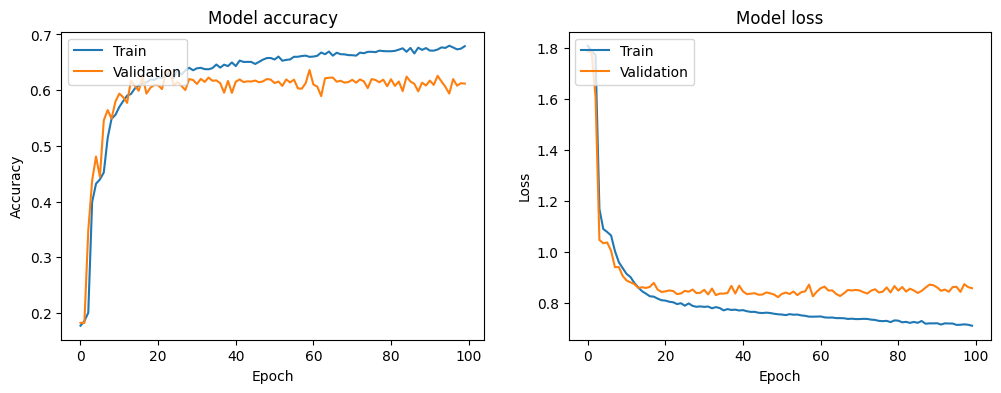

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()